# 0.0 IMPORTS

In [1]:
import os
import sys
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
sys.path.append("..")
sys.path.append('/home/nonroot/metrics')

os.chdir("..")

import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from be_great import GReaT

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from utils import set_logging_level
from metrics import *

logger = set_logging_level(logging.INFO)

%load_ext autoreload
%autoreload 2

## 0.1 Load Data

In [2]:
# Load the original data files
df = pd.read_csv('/home/nonroot/data/adult/adult.csv')

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [3]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)


len(df_train), len(df_test)

(26048, 6513)

## 0.2 Simple Analyzing

In [8]:
df_train['income'].unique()

array(['<=50K', '>50K'], dtype=object)

In [9]:
def calculate_probability_distribution(df, column_name):
    total_records = len(df)
    value_counts = df[column_name].value_counts()
    probabilities = value_counts / total_records
    return probabilities

income_prob_distribution = calculate_probability_distribution(df, 'income')
income_prob_distribution

<=50K    0.75919
>50K     0.24081
Name: income, dtype: float64

# 1.0 MODEL

In [ ]:
great = GReaT("distilgpt2",                                 # Name of the large language model used (see HuggingFace for more options)
              epochs=20,                                    # Number of epochs to train (only one epoch for demonstration) 
              batch_size=8,                           
              save_steps=2000,                             # Save model weights every x steps                      
              logging_steps=2000,                          # Log the loss and learning rate every x steps
              experiment_dir="experiments/trainer_adult"    # Name of the directory where all intermediate steps are saved
             )

# 2.0 TRAINING (Fine-tuning)

In [ ]:
trainer = great.fit(df_train, resume_from_checkpoint=True)

# 3.0 MODEL EVALUATION

In [ ]:
loss_hist = trainer.state.log_history.copy()
loss_hist.pop()

loss = [x["loss"] for x in loss_hist]
epochs = [x["epoch"] for x in loss_hist]

plt.plot(epochs, loss)

# 3.0 SAVE MODEL

In [ ]:
great.save('models/adult')

# 4.0 LOAD MODEL


In [4]:
great = GReaT.load_from_dir("models/adult")

# 5.0 GENERATE SAMPLE

In [5]:
n_samples = 500

## 5.1 Generate Using Conditional of Fine-tuning Phase

In [6]:
# Aqui, se eu não especificar a coluna de onde irá iniciar a geração do dataset, 
# ele utilizará a do fine-tuning. 

samples_finetuning_default = great.sample(n_samples, k=100, device="cuda:0")

501it [00:17, 27.97it/s]                         


In [10]:
samples_finetuning_default.shape

(500, 15)

In [11]:
samples_finetuning_default['income'].unique()

array(['<=50K', '>50K'], dtype=object)

In [12]:
income_prob_distribution = calculate_probability_distribution(samples_finetuning_default, 'income')
income_prob_distribution


<=50K    0.864
>50K     0.136
Name: income, dtype: float64

In [39]:
samples_finetuning_default.to_csv("data/adult/sample/sample_adult_sample_20epochs_distilgpt2.csv")

## 5.2 Conditional Generation Based in Categorical Feature with Weight Probability

In [14]:
df_train['age'].unique()

array([26, 24, 36, 22, 31, 43, 20, 55, 19, 46, 51, 35, 65, 68, 25, 38, 56,
       39, 29, 53, 27, 42, 41, 90, 34, 62, 21, 50, 18, 49, 60, 47, 40, 54,
       48, 37, 59, 23, 66, 57, 28, 45, 32, 44, 73, 77, 33, 17, 58, 64, 70,
       30, 61, 52, 63, 69, 78, 67, 71, 72, 74, 80, 75, 82, 79, 81, 84, 76,
       83, 87, 85, 88, 86])

In [15]:
income_prob_distribution = calculate_probability_distribution(df_train, 'age')
income_prob_distribution

31    0.028140
34    0.027641
36    0.027296
33    0.027104
37    0.027104
        ...   
83    0.000192
85    0.000077
87    0.000038
88    0.000038
86    0.000038
Name: age, Length: 73, dtype: float64

In [16]:
sample_only_1 = great.sample(n_samples, k=100, device="cuda:0", start_col='age', start_col_dist={'87': 0.3, '88': 0.2, '86': 0.3, '85':0.2})

509it [00:24, 20.65it/s]                         


In [17]:
sample_only_1['age'].unique()

array([85., 86., 87., 88.])

In [18]:
income_prob_distribution = calculate_probability_distribution(sample_only_1, 'age')
income_prob_distribution

87.0    0.330
86.0    0.306
88.0    0.194
85.0    0.170
Name: age, dtype: float64

## 5.3 Conditional Generation Based in Categorical Feature with Range Values

In [19]:
possible_ages = list(range(50, 61))

In [20]:
sample_only_1_rangevalue = great.sample(n_samples, k=100, device="cuda:0", start_col='age', start_col_dist=possible_ages)

505it [00:35, 14.33it/s]                         


In [21]:
sample_only_1_rangevalue['age'].unique()

array([60., 51., 59., 58., 56., 54., 50., 52., 53., 55., 57.])

In [22]:
income_prob_distribution = calculate_probability_distribution(sample_only_1_rangevalue, 'age')
income_prob_distribution

59.0    0.124
53.0    0.116
51.0    0.100
55.0    0.098
56.0    0.096
60.0    0.094
54.0    0.088
58.0    0.082
50.0    0.072
57.0    0.066
52.0    0.064
Name: age, dtype: float64

## 5.4 Conditional Generation Based in Prompts

In [23]:
prompt1 = "Age is 25, Sex is male"
generated_samples1 = great.great_sample(starting_prompts=prompt1, temperature=0.7, max_length=200)


In [24]:
generated_samples1.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,None,Private,172591,HS-grad,9,Never-married,Handlers-cleaners,Own-child,White,None,0,0,40,United-States,<=50K


## 5.5 Data Imputation

In [25]:

missing_data = great.sample(n_samples, k=100, device="cuda:0", start_col='income', start_col_dist={'<=50K': 0.30, '>50K': 0.50, 'NaN': 0.20})


506it [00:18, 26.81it/s]                         


In [26]:
missing_data['income'].unique()

array(['NaN', '>50K', '<=50K'], dtype=object)

In [27]:
missing_data.replace("NaN", np.nan, inplace=True)

In [28]:
missing_data.isnull().sum()

age                 0
workclass           0
fnlwgt              0
education           0
education.num       0
marital.status      0
occupation          0
relationship        0
race                0
sex                 0
capital.gain        0
capital.loss        0
hours.per.week      0
native.country      0
income            109
dtype: int64

In [22]:
income_prob_distribution = calculate_probability_distribution(missing_data, 'income')
income_prob_distribution

<=50K    0.386
>50K     0.376
Name: income, dtype: float64

In [29]:
df_imputed = great.impute(missing_data, temperature=0.7, k=100, max_length=200)

100%|██████████| 500/500 [00:11<00:00, 44.62it/s]


In [30]:
df_imputed['income'].unique()

array(['>50K', '<=50K'], dtype=object)

In [31]:
income_prob_distribution = calculate_probability_distribution(df_imputed, 'income')
income_prob_distribution

<=50K    0.562
>50K     0.438
Name: income, dtype: float64

In [32]:
df_imputed.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

# 6.0 DATASET EVALUATION

In [33]:
model = GReaT.load_from_dir("models/adult")

In [34]:
# Load the original data files
dp = DataProvider(df_train[:2000], df_test[:500], {"adult": model})

Generating data for model adult ...


2006it [01:08, 29.22it/s]                          
100%|██████████| 500/500 [00:17<00:00, 29.22it/s]


In [21]:
dp.get_full_data("original", train=True).shape

(2000, 15)

In [22]:
dp.get_full_data("original", train=False).shape

(500, 15)

## 6.1 Discriminator metric

In [31]:
disc_metric = DiscriminatorMetric(dp, accuracy_score, n_runs = 4)

In [32]:
metric_result = disc_metric("adult", "adult")

2023-08-25 05:57:10,211 - INFO - Inside of get_full_data()... (data_provider.py:41)
2023-08-25 05:57:10,211 - INFO - Model Type is original? original (data_provider.py:43)
2023-08-25 05:57:10,212 - INFO - Get Original Dataset Train (data_provider.py:45)


metrics/config/adult/config.json
metrics/config/adult/config.json


/home/nonroot/metrics/discriminator_metric.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[discrete_cols] = self.cat_encoder.transform(df_train[discrete_cols])
2023-08-25 05:57:10,624 - INFO - Inside of get_full_data()... (data_provider.py:41)
2023-08-25 05:57:10,624 - INFO - Dont model type original (data_provider.py:51)
2023-08-25 05:57:10,625 - INFO - Get Non-Original Dataset Train (data_provider.py:53)
2023-08-25 05:57:10,638 - INFO - Inside of get_full_data()... (data_provider.py:41)
2023-08-25 05:57:10,639 - INFO - Model Type is original? original (data_provider.py:43)
2023-08-25 05:57:10,639 - INFO - Get Original Dataset Test (data_provider.py:48)
/home/nonroot/metrics/discriminator_metric.py:86: SettingWithCopyWarning: 
A va

In [33]:
metric_result

{'discriminator_mean': 0.7905000000000001,
 'discriminator_std': 0.004031128874149278}

## 6.2 Machine Learning Efficiency Metric

In [41]:
mle = MLEfficiency(dp, model=RandomForestClassifier, metric=accuracy_score, params={"n_estimators": 100})

In [ ]:
results = mle(dataset_name="adult", model_name="adult")


## 6.3 Distance to closest record

In [35]:
dtcr_metric = DTCR(dp, n_samples=500)

In [36]:
metric_res = dtcr_metric("adult", "adult")

2023-08-25 12:37:40,872 - INFO - Inside of get_full_data()... (data_provider.py:41)
2023-08-25 12:37:40,873 - INFO - Model Type is original? original (data_provider.py:43)
2023-08-25 12:37:40,873 - INFO - Get Original Dataset Train (data_provider.py:45)


metrics/config/adult/config.json
metrics/config/adult/config.json
(500, 15)


(0.0, 500.0)

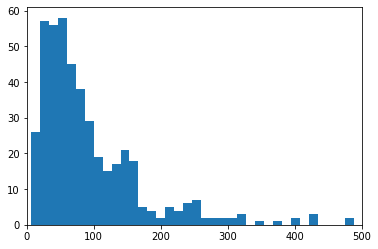

In [37]:
plt.hist(metric_res["mins"], bins=1500)
plt.xlim([0,500])

In [38]:
min_arr = np.array(metric_res["mins"])
print("Identical records: ", np.sum(min_arr==0), "of", len(min_arr))

Identical records:  0 of 500


In [39]:
## How many duplicates in one generated dataset?
ndr = NonDuplicateRate(dp, n_samples=500)

In [40]:
ndr("adult", "adult")

{'non_dup_rate': 0.878}